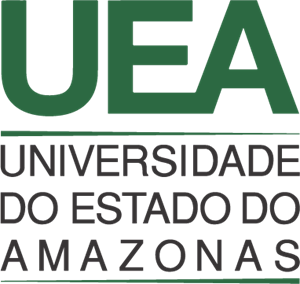

- Módulo: Machine Learning Aplicado I

- Equipe: EAD

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

In [88]:
# install
!pip install xgboost
!pip install catboost
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 709 kB/s 


##General Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import xgboost
import catboost
import lightgbm as lgb

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Install Shap

In [2]:
!pip install shap

##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [3]:
!pip install kaggle

###Get Files

In [4]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/aml-t2-fw/data
  !kaggle competitions download -c aml-t2-fw
  !ls -la ./
  !unzip ./Dados_Teste.csv.zip
  !unzip ./Dados_Treino.csv.zip
  !ls -la ./

Run this function to import your API.

In order to get you key, got to **Kaggle** > Account > Create New API Token

Import `kaggle.json` file

In [5]:
import_kaggle_api_key()

In [6]:
get_data_from_competition()

# download em ambiente local
# !kaggle competitions download -c aml-t2-fw
# !unzip ./aml-t2-fw.zip


 93%|███████████████████████████████████▎  | 21.0M/22.6M [00:01<00:00, 11.2MB/s]
100%|██████████████████████████████████████| 22.6M/22.6M [00:01<00:00, 13.7MB/s]
total 23964
drwxrwxr-x 2 andrewsas andrewsas     4096 jul 31 11:05 .
drwxrwxr-x 9 andrewsas andrewsas     4096 jul 19 22:42 ..
-rw-rw-r-- 1 andrewsas andrewsas 23700274 jul 31 11:05 aml-t2-fw.zip
-rw-rw-r-- 1 andrewsas andrewsas   825030 jul 31 11:05 machine_learning_aplicado_I.ipynb
unzip:  cannot find or open ./Dados_Teste.csv.zip, ./Dados_Teste.csv.zip.zip or ./Dados_Teste.csv.zip.ZIP.
unzip:  cannot find or open ./Dados_Treino.csv.zip, ./Dados_Treino.csv.zip.zip or ./Dados_Treino.csv.zip.ZIP.
total 23964
drwxrwxr-x 2 andrewsas andrewsas     4096 jul 31 11:05 .
drwxrwxr-x 9 andrewsas andrewsas     4096 jul 19 22:42 ..
-rw-rw-r-- 1 andrewsas andrewsas 23700274 jul 31 11:05 aml-t2-fw.zip
-rw-rw-r-- 1 andrewsas andrewsas   825030 jul 31 11:05 machine_learning_aplicado_I.ipynb
aml-t2-fw.zip: Skipping, found more recently modifi

##Datasets


###Initial view

In [7]:
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')
df_dict_dados = pd.read_csv('./Dicionario_de_Dados.csv')
df_template_sub = pd.read_csv('./Template_Submissao.csv')

In [8]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

Dados de Treino

In [9]:
df_dados_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0

In [10]:
explore_dataset(df_dados_treino)

(117141, 180)
--------------------
       encounter_id  hospital_id        age        bmi  elective_surgery  \
count     117141.00    117141.00  112653.00  113106.00         117141.00   
mean      213013.98       106.22      62.01      29.12              0.19   
std        38128.78        63.48      16.83       8.28              0.39   
min       147001.00         1.00       0.00      14.84              0.00   
25%       179951.00        50.00      52.00      23.60              0.00   
50%       213051.00       112.00      64.00      27.57              0.00   
75%       246063.00       165.00      75.00      32.82              0.00   
max       279000.00       204.00      89.00      67.81              1.00   

          height     icu_id  pre_icu_los_days  readmission_status     weight  \
count  115286.00  117141.00         117141.00            117141.0  114021.00   
mean      169.60     662.94              0.84                 0.0      83.81   
std        10.84     304.33             

Dados de Teste

In [11]:
df_dados_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,42,35.0,29.060607,0,Caucasian,F,169.0,Emergency Department,Accident & Emergency,1044,admit,Med-Surg ICU,0.161806,0,83.0,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,91.0,120.0,NaN,0,68.0,NaN,NaN,NaN,NaN,39.0,NaN,34.7,1708.3872,1,NaN,NaN,NaN,86.0,54.0,86.0,54.0,120.0,72.0,NaN,NaN,97.333333,68.333333,97.333333,68.333333,44.0,15.0,100.0,94.0,NaN,NaN,140.0,92.0,140.0,92.0,38.7,34.7,NaN,NaN,83.0,67.0,83.0,67.0,80.0,73.0,NaN,NaN,97.333333,79.0,97.333333,79.0,15.0,15.0,100.0,100.0,NaN,NaN,126.0,103.0,126.0,103.0,34.7,34.7,2.7,2.7,NaN,NaN,8.0,8.0,NaN,NaN,0.87,0.87,108.0,91.0,21.0,21.0,12.6,12.6,37.0,37.0,NaN,NaN,NaN,NaN,259.0,259.0,3.5,3.5,142.0,142.0,18.60,18.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,220057,100,84.0,23.128938,0,Caucasian,F,170.2,Emergency Department,Accident & Emergency,490,admit,Med-Surg ICU,0.040972,0,67.0,NaN,301.0,403.01,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,4.0,232.0,107.0,NaN,0,57.0,NaN,NaN,NaN,NaN,25.0,NaN,36.0,852.59

In [12]:
explore_dataset(df_dados_teste)

(13016, 179)
--------------------
       encounter_id  hospital_id       age       bmi  elective_surgery  \
count      13016.00     13016.00  12516.00  12561.00          13016.00   
mean      212882.75       105.04     61.87     29.02              0.19   
std        37940.12        63.46     16.80      8.09              0.39   
min       147000.00         1.00      0.00     14.84              0.00   
25%       180537.25        47.00     52.00     23.61              0.00   
50%       212676.50       110.00     64.00     27.55              0.00   
75%       245433.25       163.00     75.00     32.61              0.00   
max       278994.00       204.00     89.00     67.81              1.00   

         height    icu_id  pre_icu_los_days  readmission_status    weight  \
count  12794.00  13016.00          13016.00             13016.0  12673.00   
mean     169.64    657.86              0.82                 0.0     83.66   
std       10.81    303.61              2.31                 0.0     

###ETL

Pré-processamento de dados de treino e teste

In [13]:
#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

#Treat numeric values from dataframe
def str_to_num(df_aux, index):
  for i in index:
    col_name = df_aux.columns[i]
    # df_aux[col_name] = df_aux[col_name].str.replace('.', '')
    # df_aux[col_name] = df_aux[col_name].str.replace(',', '.')
    df_aux[col_name] = pd.to_numeric(df_aux[col_name])
  return df_aux

#Scale numeric values
def apply_scale_for_num(df):
  # columns_num = df.loc[:,'age':'solid_tumor_with_metastasis'].select_dtypes(include=['int64', 'float64']).columns
  columns_num = df.loc[:,'gcs_eyes_apache':'solid_tumor_with_metastasis'].select_dtypes(include=['int64', 'float64']).columns
  df_aux = df[columns_num]

  min_max_scaler = MinMaxScaler().fit(df_aux.values)
  df_aux = min_max_scaler.transform(df_aux.values)
  df[columns_num] = df_aux
  return df

In [14]:
fields_to_tranform = ['ethnicity', 'gender']
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

# Change field type
df_dados_teste = str_to_num(df_dados_teste, [3])
df_dados_treino = str_to_num(df_dados_treino, [3])

In [15]:
#Remove columns
rm_columns = ['bmi', 'hospital_id','hospital_admit_source', 'icu_admit_source',
              'icu_id', 'pre_icu_los_days', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 
              'readmission_status', 'apache_3j_diagnosis', 'height']

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

In [16]:
#Replace NaN values with 0
df_dados_teste = df_dados_teste.fillna(0)
df_dados_treino = df_dados_treino.fillna(0)

In [17]:
#Check NaN values
print(np.any(np.isnan(df_dados_teste)))
print(np.any(np.isnan(df_dados_treino)))

False
False


In [18]:
df_dados_teste = apply_scale_for_num(df_dados_teste.copy())
df_dados_treino = apply_scale_for_num(df_dados_treino.copy())
df_dados_teste

,encounter_id,age,elective_surgery,ethnicity,gender,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,35.0,0,2,0,83.0,0.0,0,0,0.0,0.0,0.00,0.0,0.00,0.000000,1.0,0.0,0.151996,0.674157,0.000000,0.0,0.340,0.000000,0.000000,0.000000,0.000000,0.650000,0.000000,0.874055,0.195991,1.0,0.000000,0.000000,0.000000,0.521212,0.600000,0.521212,0.600000,0.677966,0.473684,0.000000,0.000000,0.528986,0.610119,0.537753,0.610119,0.478261,0.217391,1.00,0.94,0.000000,0.000000,0.603448,0.57500,0.603448,0.57500,0.969925,0.917989,0.000000,0.000000,0.580420,0.592920,0.576389,0.587719,0.487805,0.506944,0.000000,0.000000,0.589899,0.572464,0.597137,0.572464,0.254237,0.127119,1.00,1.00,0.000000,0.000000,0.565022,0.530928,0.565022,0.528205,0.878481,0.882952,0.586957,0.600000,0.000000,0.000000,0.063492,0.070740,0.000000,0.000000,0.078308,0.087544,0.176759,0.315972,0.525,0.538462,0.732558,0.754491,0.718447,0.740,0.000000,0.000000,0.000000,0.000000,0.442735,0.464616,0.500000,0.603448,0.898734,0.928105,0.403646,0.454790,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155386,0.161194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

##Machine Learning Algorithms

Algoritmos utilizados para prever a presença de Diabetes em pacientes

### Utility Functions to help the process

In [19]:
def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_knn_model(neighbors, X_tr, X_ts, y_tr, y_ts):
  model = KNeighborsClassifier(n_neighbors=neighbors)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def create_tree_model(depth, X_tr, X_ts, y_tr, y_ts):
  tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)

  tree_model.fit(X_tr, y_tr)
  print_model_result(tree_model, X_tr, X_ts, y_tr, y_ts)
  return tree_model

def create_logistic_model(X_tr, X_ts, y_tr, y_ts):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_tr, y_tr)
  print_model_result(logistic_model, X_tr, X_ts, y_tr, y_ts)
  return logistic_model

def create_random_forest_model(depth, estimators, X_tr, X_ts, y_tr, y_ts):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

In [20]:
def upload_submit(path, msg):
  !kaggle competitions submit -c aml-t2-fw -f '{path}' -m f"Descrição: {msg}"

def send_submit(df, msg):
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  df.to_csv(f'submit_{timestamp}.csv', index=False)
  upload_submit(f'submit_{timestamp}.csv', msg)


def update_df_template(df, df_result_test):
  df['diabetes_mellitus'] = df_result_test.loc[df_result_test['encounter_id'] == df['encounter_id']]['predict']
  return df

def get_dataframe_for_submission(model):
  df_result = df_dados_teste.copy()
  df_result_template = df_template_sub.copy()
  df_result['predict'] = model.predict_proba(df_result)[:,1]
  df_result_template = df_result_template.apply(lambda x: update_df_template(x, df_result), axis=1)
  df_result_template = df_result_template.astype({'encounter_id': 'int64'})
  return df_result_template

def view_result(df_result_view):
  df_result_view = round(df_result_view, 2)
  plt.figure(figsize = (16,10))
  ax = sns.countplot(x = 'diabetes_mellitus', 
                    data = df_result_view)

  ax.set_title('Previsão de Pacientes Diabéticos')
  ax.set_xlabel('Diabético')
  ax.set_ylabel('Qtd. de pacientes')
  plt.xticks(rotation=45)
  plt.show()

In [21]:
now = datetime.now()
timestamp = datetime.timestamp(now)
print(f"submit_{timestamp}.csv")
  

submit_1627743937.954967.csv


### Treinamento dos Modelos

In [22]:
X = df_dados_treino.loc[:,'encounter_id':'solid_tumor_with_metastasis'].to_numpy()

y = df_dados_treino['diabetes_mellitus'].to_numpy()

In [23]:
print(X)

[[2.14826e+05 6.80000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.46060e+05 7.70000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.62220e+05 8.10000e+01 1.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [2.19719e+05 7.30000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.22562e+05 8.10000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.57942e+05 3.50000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


In [24]:
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.25, random=0)

Amostras de treino:
 * X_train: (87855, 167)
 * y_train: (87855,)
Amostras de teste:
 * X_test: (29286, 167)
 * y_test: (29286,)


#### KNN - k vizinhos mais próximos
Treino do Modelo utilizando a algoritmo KNN

****************** KNN ******************
Acurácia (Treino): 0.8
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.79      0.98      0.87     22952
         YES       0.36      0.05      0.08      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.51      0.48     29286
weighted avg       0.70      0.78      0.70     29286



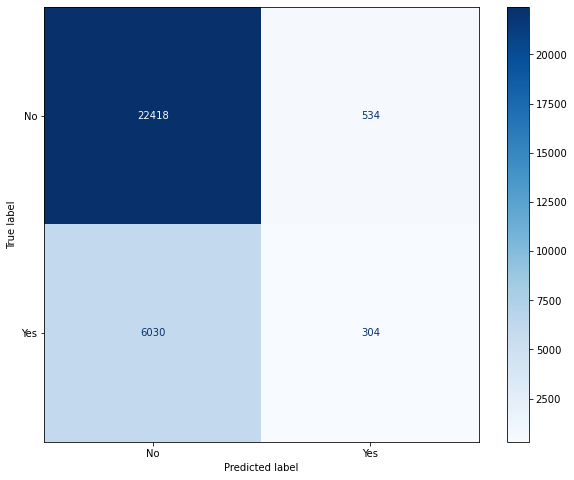

In [25]:
print('****************** KNN ******************')

knn_model = create_knn_model(neighbors=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

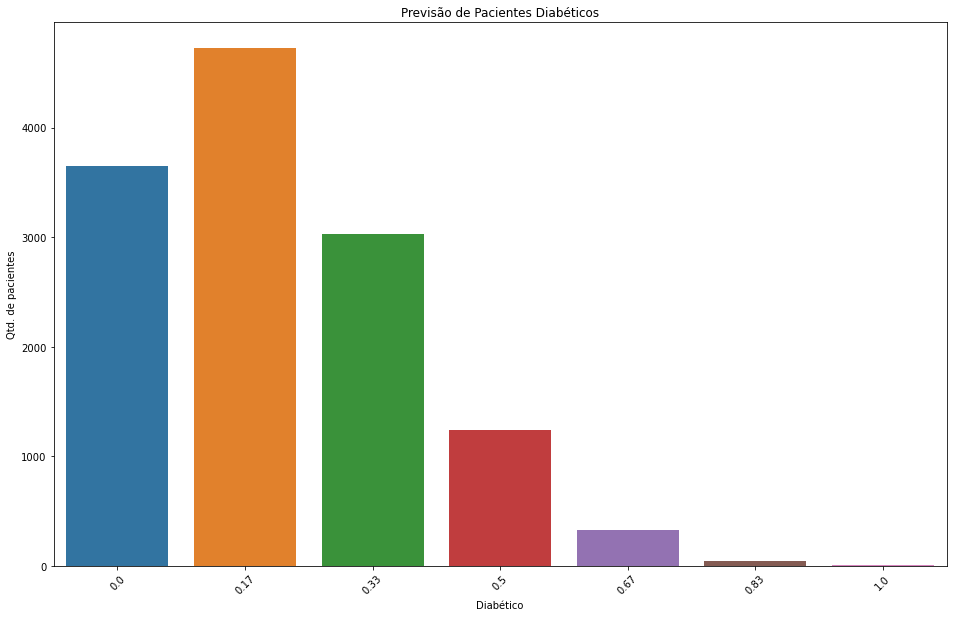

In [26]:
result_knn = get_dataframe_for_submission(knn_model)
view_result(result_knn)

In [27]:
# envia para o kagle o df com o resultado gerado
send_submit(result_knn, 'Teste 4 knn')

100%|████████████████████████████████████████| 263k/263k [00:03<00:00, 69.8kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Decision Tree
Treino do Modelo utilizando a algoritmo Árvore de decisão

****************** ARVORE ******************
Acurácia (Treino): 0.82
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.86      0.91      0.88     22952
         YES       0.58      0.44      0.50      6334

    accuracy                           0.81     29286
   macro avg       0.72      0.68      0.69     29286
weighted avg       0.80      0.81      0.80     29286



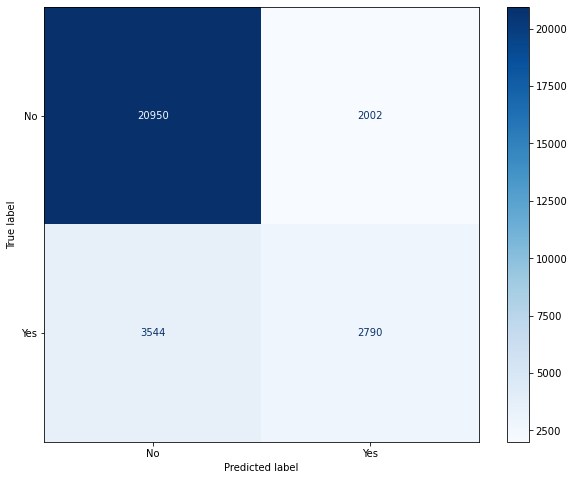

In [28]:
print('****************** ARVORE ******************')

tree_model = create_tree_model(depth=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

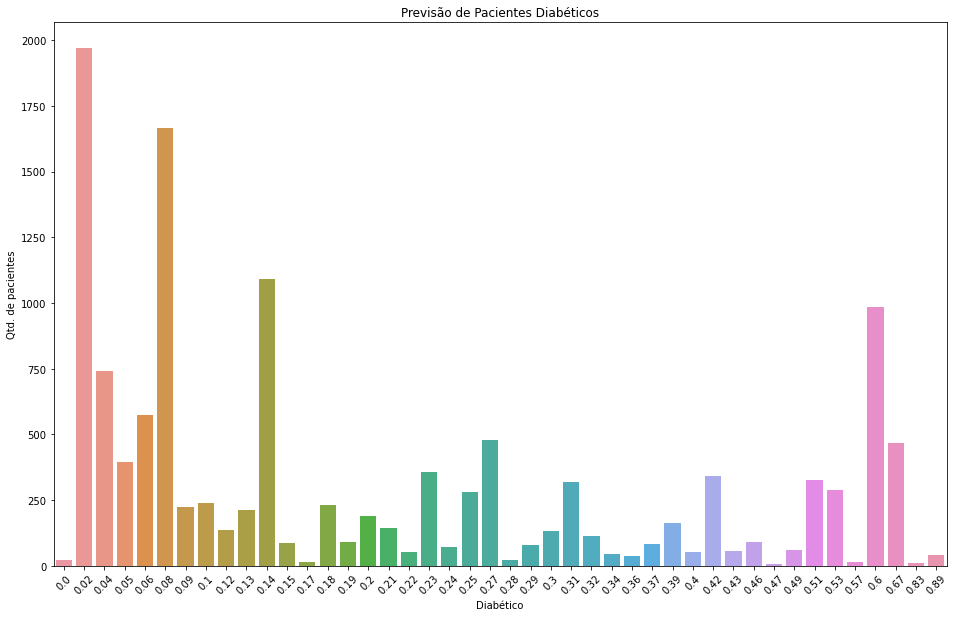

In [29]:
# gera o df para submissão com base no template
result_tree = get_dataframe_for_submission(tree_model)
view_result(result_tree)

In [30]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree, 'Teste 5 decision tree')

100%|████████████████████████████████████████| 339k/339k [00:03<00:00, 88.5kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Logistic Regression
Treino do Modelo utilizando a algoritmo de Regressão Logística

****************** Regressão Logística ******************
Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.37      0.01      0.02      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.50      0.45     29286
weighted avg       0.69      0.78      0.69     29286



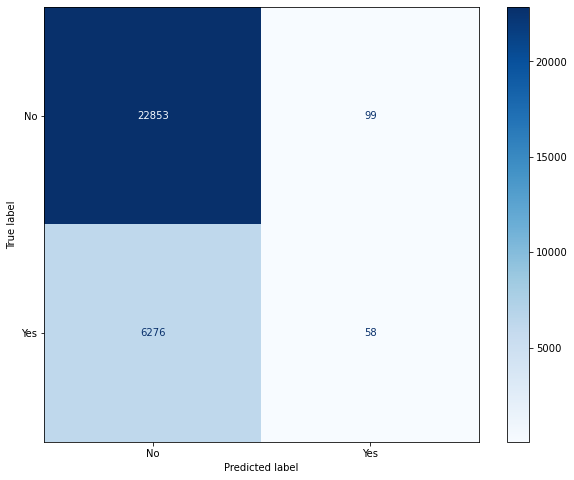

In [31]:
print('****************** Regressão Logística ******************')

logistic_model = create_logistic_model(X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

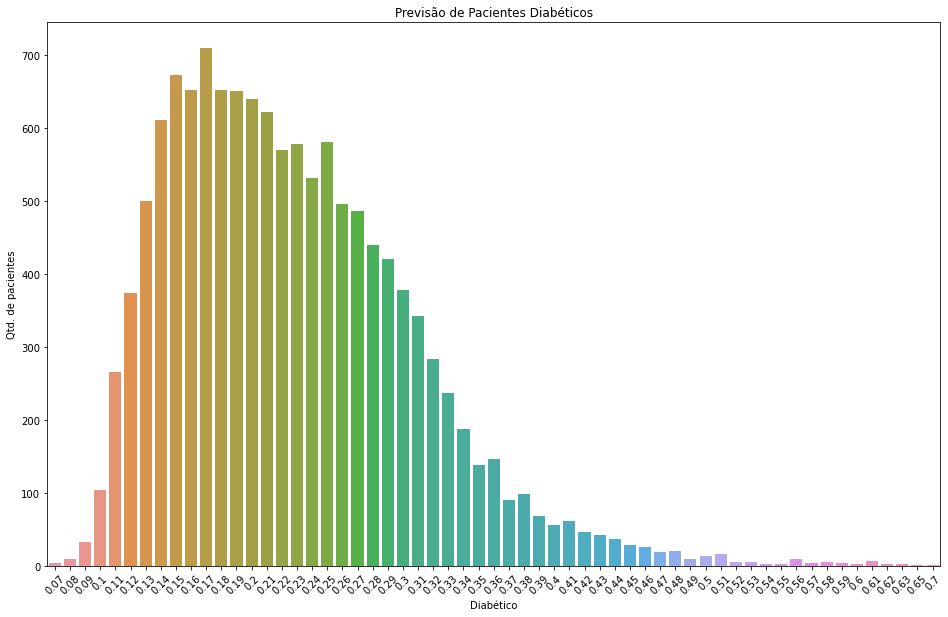

In [32]:
# gera o df para submissão com base no template
result_logistic = get_dataframe_for_submission(logistic_model)
view_result(result_logistic)

In [33]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic, 'Teste 2 logistic regression')

100%|████████████████████████████████████████| 338k/338k [00:04<00:00, 77.2kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Random Forest
Treino do Modelo utilizando a algoritmo de Random Forest

****************** Random Forest ******************
Acurácia (Treino): 0.93
Acurácia (Teste): 0.82
              precision    recall  f1-score   support

          NO       0.84      0.95      0.89     22952
         YES       0.65      0.33      0.44      6334

    accuracy                           0.82     29286
   macro avg       0.74      0.64      0.66     29286
weighted avg       0.80      0.82      0.79     29286



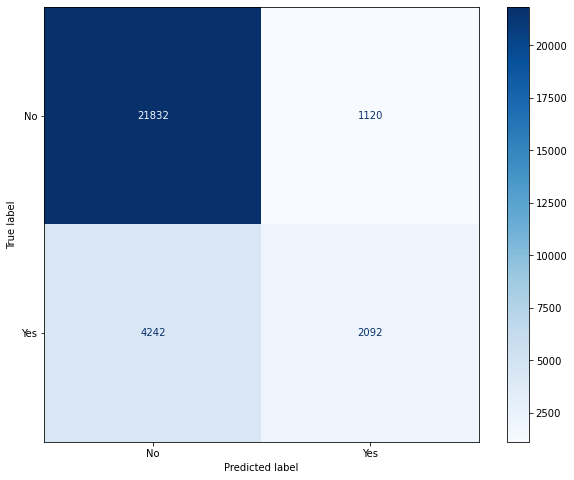

In [34]:
print('****************** Random Forest ******************')

random_forest_model = create_random_forest_model(depth=16, estimators=100, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

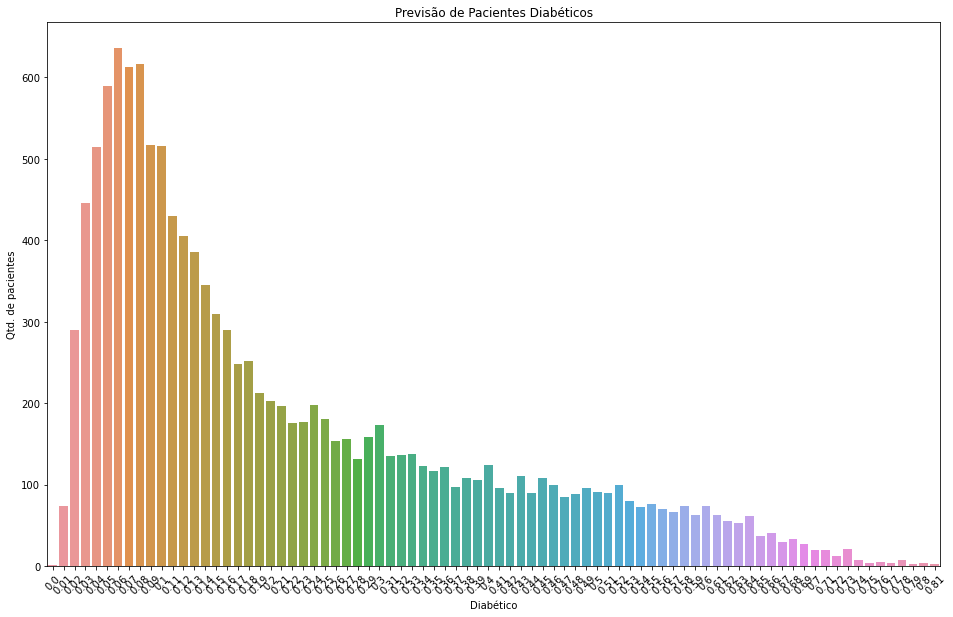

In [35]:
result_random_forest = get_dataframe_for_submission(random_forest_model)
view_result(result_random_forest)

In [36]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_random_forest, '9 Random Forest: depth=16, estimators=100')

### Ensemble Learning

Possible metrics to choose

In [37]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [38]:
#@title Choose metric
work_metric = "roc_auc" #@param ["roc_auc", "accuracy"]

Functions to help Ensemble process

In [39]:
def create_ens_logistic_model():
  model = LogisticRegression()
  return model

def create_ens_decision_tree(depth):
  model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)
  return model

def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')

def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

#### Logistic Regression 

In [40]:
ens_logistic_model = LogisticRegression()

In [41]:
print('****************** ENSEMBLE Regressão Logística ******************')
ens_logistic_model = create_cross_validation_model(ens_logistic_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Regressão Logística ******************
Cross Validation Result

roc_auc: [0.56685403 0.58099198 0.57439339 0.57977208 0.57842064]

roc_auc (média): 0.5761
roc_auc (desvio padrão): 0.0051


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.37      0.01      0.02      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.50      0.45     29286
weighted avg       0.69      0.78      0.69     29286



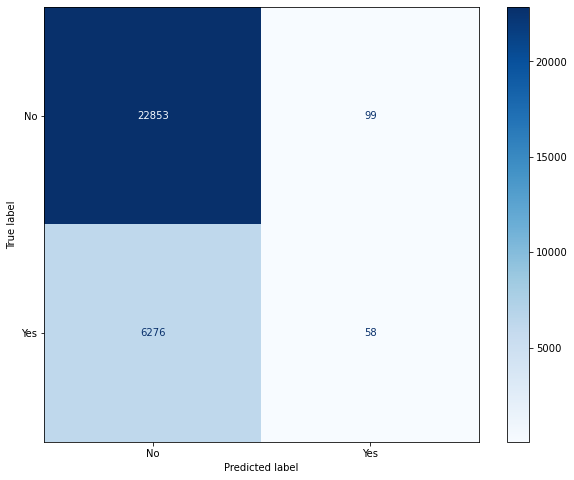

In [42]:
ens_logistic_model = validate_ens_model(ens_logistic_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

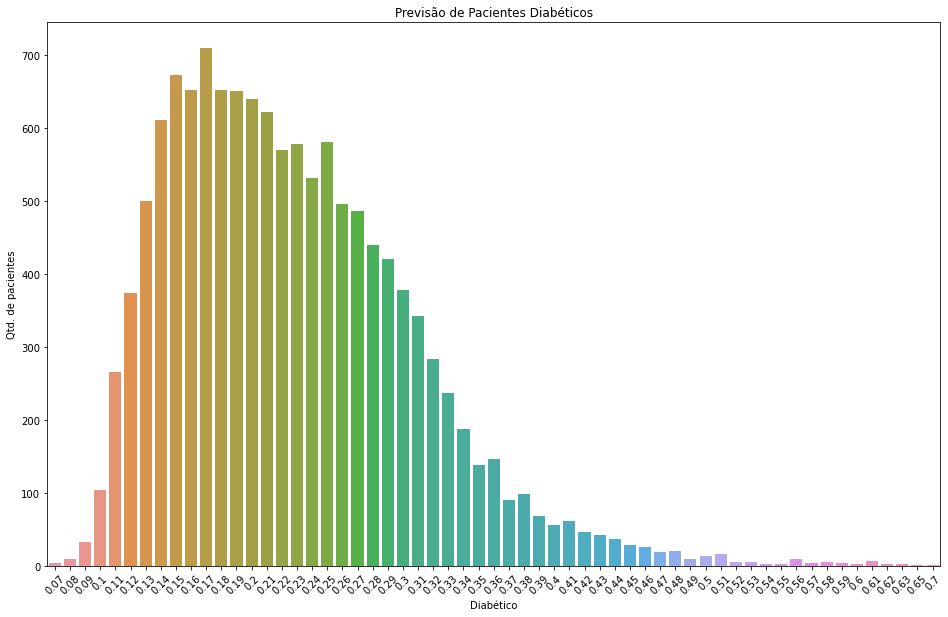

In [43]:
result_logistic_ens = get_dataframe_for_submission(ens_logistic_model)
view_result(result_logistic_ens)

In [44]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_logistic_ens, 'Ensemble 2 logistic regression')

#### Decision Tree

In [45]:
ens_tree_model = create_ens_decision_tree(6)

In [46]:
print('****************** ENSEMBLE Árvore de Decisão ******************')
ens_tree_model = create_cross_validation_model(ens_tree_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Árvore de Decisão ******************
Cross Validation Result

roc_auc: [0.81352342 0.80303853 0.80989566 0.82164911 0.81218648 0.80728421
 0.80093055 0.80179256 0.80388536 0.79992072]

roc_auc (média): 0.8074
roc_auc (desvio padrão): 0.0066


Acurácia (Treino): 0.82
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.86      0.91      0.88     22952
         YES       0.58      0.44      0.50      6334

    accuracy                           0.81     29286
   macro avg       0.72      0.68      0.69     29286
weighted avg       0.80      0.81      0.80     29286



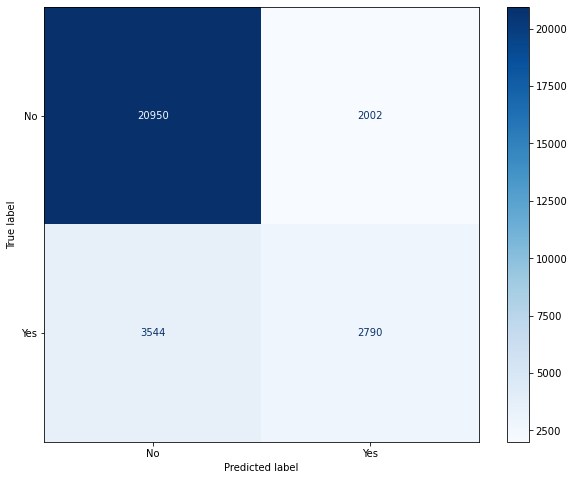

In [47]:
ens_tree_model = validate_ens_model(ens_tree_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

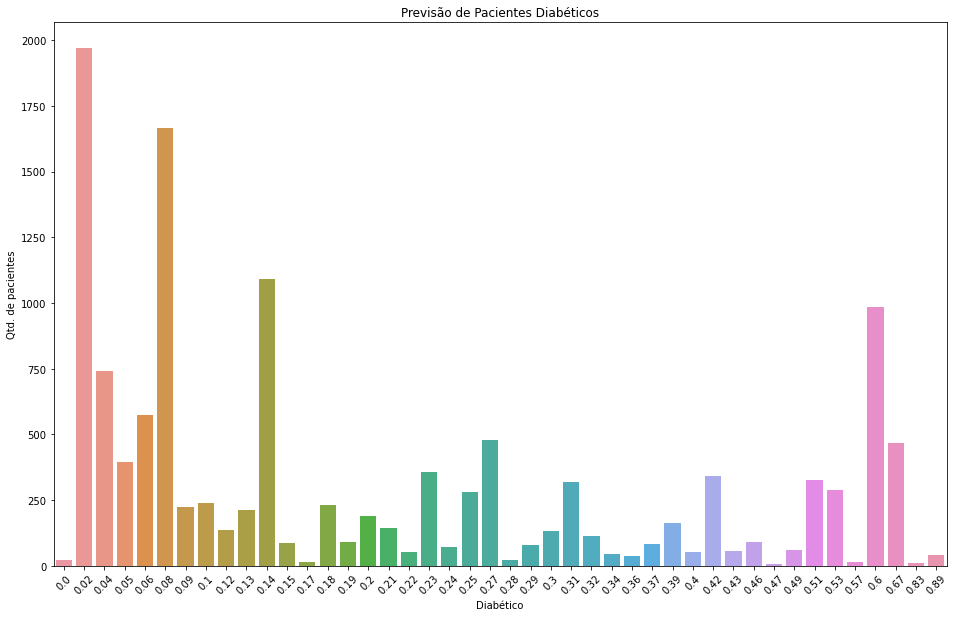

In [48]:
result_tree_ens = get_dataframe_for_submission(ens_tree_model)
view_result(result_tree_ens)

In [49]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_tree_ens, 'Ensemble 5 Decision Tree')

#### Random Forest

In [50]:
ens_random_forest_model = create_ens_random_forest(16, 100)

In [98]:
print('****************** ENSEMBLE Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Random Forest ******************
Cross Validation Result

roc_auc: [0.82999519 0.82955283 0.8236793 ]

roc_auc (média): 0.8277
roc_auc (desvio padrão): 0.0029


Acurácia (Treino): 0.93
Acurácia (Teste): 0.82
              precision    recall  f1-score   support

          NO       0.84      0.95      0.89     22952
         YES       0.65      0.33      0.44      6334

    accuracy                           0.82     29286
   macro avg       0.74      0.64      0.66     29286
weighted avg       0.80      0.82      0.79     29286



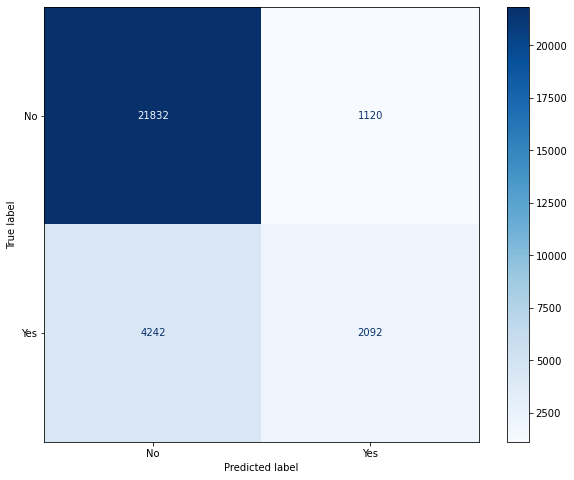

In [99]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

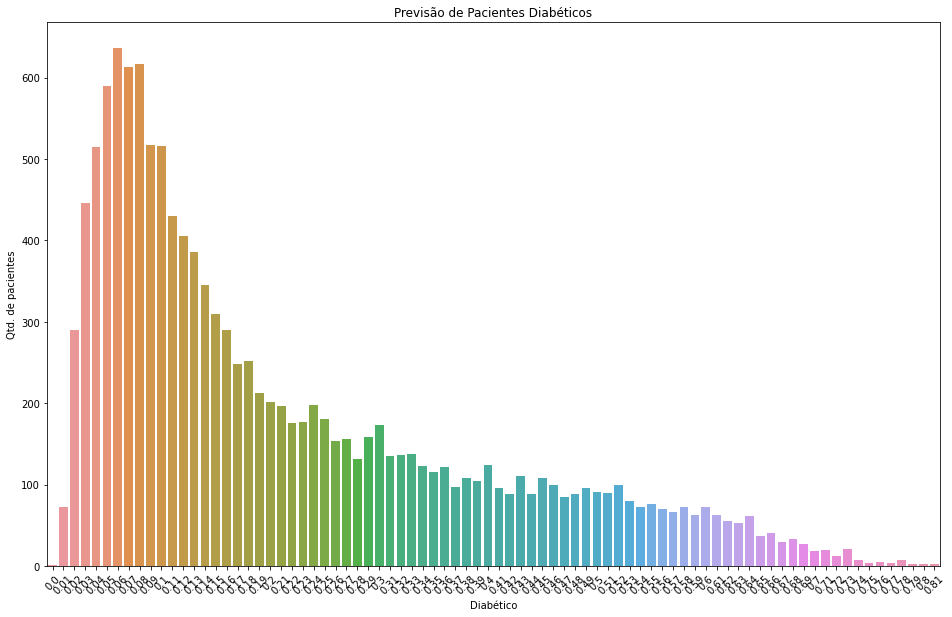

In [ ]:
result_random_forest_ens = get_dataframe_for_submission(ens_random_forest_model)
view_result(result_random_forest_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_random_forest_ens, 'Ensemble 2 Random Forest: depth=16, estimators=100')

100% 339k/339k [00:02<00:00, 172kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Soft Voting
Voting Classifier

In [53]:
# metodos Ensemble Learning
# OBS hard não tem o predic_prob 
def get_voting_classifier(estimators, voting='soft'):
    return VotingClassifier(estimators = estimators, voting=voting)


In [54]:

soft_voting_model = get_voting_classifier([('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'soft')

In [56]:
print('****************** ENSEMBLE Soft Voting Classifier ******************')
soft_voting_model = create_cross_validation_model(soft_voting_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft Voting Classifier ******************
Cross Validation Result

roc_auc: [0.82807075 0.82757169 0.81967882]

roc_auc (média): 0.8251
roc_auc (desvio padrão): 0.0038


Acurácia (Treino): 0.88
Acurácia (Teste): 0.82
              precision    recall  f1-score   support

          NO       0.84      0.94      0.89     22952
         YES       0.63      0.37      0.47      6334

    accuracy                           0.82     29286
   macro avg       0.74      0.65      0.68     29286
weighted avg       0.80      0.82      0.80     29286



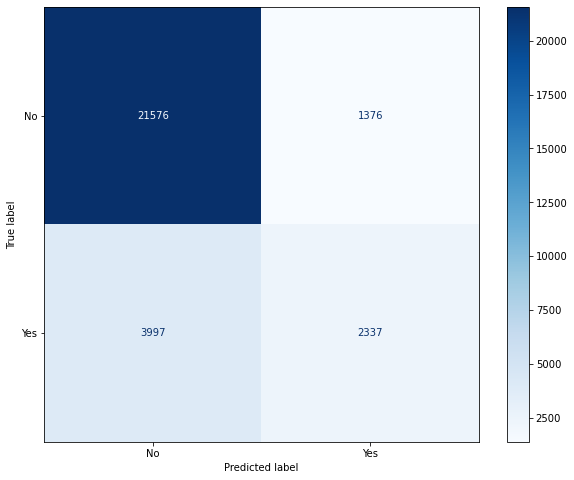

In [57]:
soft_voting_model = validate_ens_model(soft_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

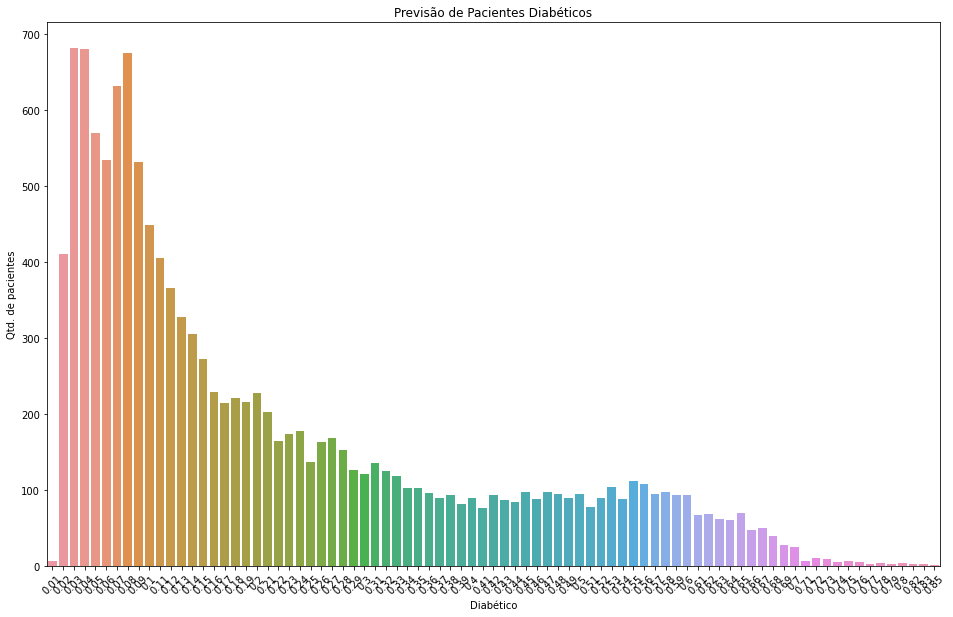

In [ ]:
result_soft_voting = get_dataframe_for_submission(soft_voting_model)
view_result(result_soft_voting)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_soft_voting, 'Ensemble 2 Soft Voting Classifier')

100% 339k/339k [00:01<00:00, 208kB/s]
400 - Bad Request


In [91]:

hard_voting_model = get_voting_classifier([('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'hard')

In [95]:
print('****************** ENSEMBLE Hard Voting Classifier ******************')
hard_voting_model = create_cross_validation_model(hard_voting_model, 3, 'accuracy', X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Hard Voting Classifier ******************
Cross Validation Result

accuracy: [0.81854192 0.81198566 0.81034659]

accuracy (média): 0.8136
accuracy (desvio padrão): 0.0035


Acurácia (Treino): 0.87
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.83      0.96      0.89     22952
         YES       0.66      0.29      0.41      6334

    accuracy                           0.81     29286
   macro avg       0.75      0.63      0.65     29286
weighted avg       0.79      0.81      0.79     29286



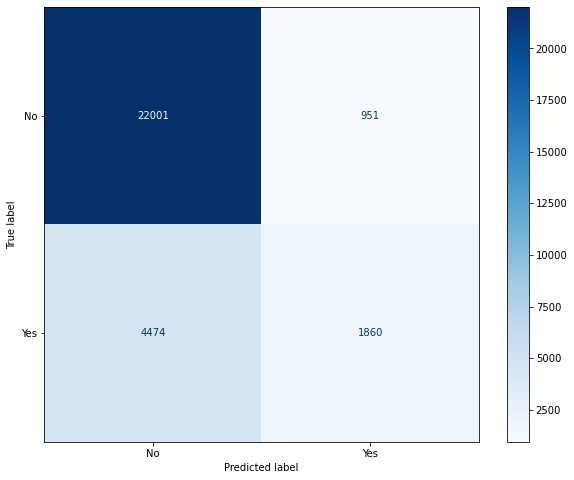

In [96]:
hard_voting_model = validate_ens_model(hard_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [97]:

# result_hard_voting = get_dataframe_for_submission(hard_voting_model)

AttributeError: predict_proba is not available when voting='hard'

In [60]:
# send_submit(result_soft_voting, 'Ensemble 2 Hard Voting Classifier')


     |████████████████████████████████| 166.7 MB 28.2 MB/s 


In [63]:
# XGBoost
xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
                                  learning_rate = 0.005,
                                  n_estimators = 50,
                                  max_depth = 4,
                                  random_state = 0)


In [65]:
print('****************** XGBoost ******************')
xgb_model = create_cross_validation_model(xgb_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** XGBoost ******************
[11:31:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation Result

roc_auc: [0.80718967 0.807487   0.7996666 ]

roc_auc (média): 0.8048
roc_auc (desvio padrão): 0.0036


[11:33:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia (Treino): 0.81
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.84      0.93      0.89     22952
         YES       0.60      0.36      0.45      6334

    accuracy                           0.81     29286
   macro avg       0.72      0.65      0.67     29286
weighted avg       0.79      0.81      0.79     29286



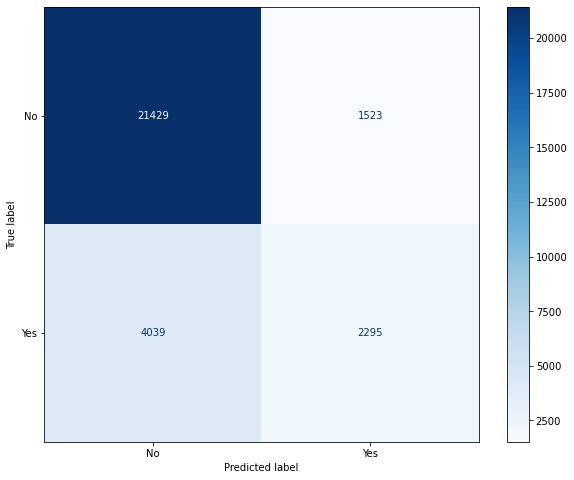

In [69]:
xgb_model = validate_ens_model(xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [70]:
result_xgb_model = get_dataframe_for_submission(xgb_model)

In [71]:
# send_submit(result_xgb_model, 'XGBoost')

100%|█████████████████████████████████████████| 330k/330k [00:02<00:00, 119kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

In [79]:
 cat_boost_model = catboost.CatBoostClassifier(iterations=5,
                         learning_rate=0.005,
                         depth=5,
                         random_state=0)

In [80]:
print('****************** CatBoost ******************')
cat_boost_model = create_cross_validation_model(cat_boost_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** CatBoost ******************
0:	learn: 0.6903389	total: 39.4ms	remaining: 157ms
1:	learn: 0.6873375	total: 78ms	remaining: 117ms
2:	learn: 0.6843397	total: 117ms	remaining: 77.9ms
3:	learn: 0.6812588	total: 158ms	remaining: 39.4ms
4:	learn: 0.6784722	total: 202ms	remaining: 0us
0:	learn: 0.6902916	total: 46.8ms	remaining: 187ms
1:	learn: 0.6873084	total: 86.9ms	remaining: 130ms
2:	learn: 0.6842404	total: 125ms	remaining: 83.1ms
3:	learn: 0.6812881	total: 170ms	remaining: 42.4ms
4:	learn: 0.6785727	total: 210ms	remaining: 0us
0:	learn: 0.6902521	total: 43.7ms	remaining: 175ms
1:	learn: 0.6871931	total: 85.5ms	remaining: 128ms
2:	learn: 0.6840970	total: 127ms	remaining: 84.9ms
3:	learn: 0.6809774	total: 164ms	remaining: 41ms
4:	learn: 0.6781892	total: 204ms	remaining: 0us
Cross Validation Result

roc_auc: [0.79505907 0.78980214 0.7829633 ]

roc_auc (média): 0.7893
roc_auc (desvio padrão): 0.005


0:	learn: 0.6902852	total: 52ms	remaining: 208ms
1:	learn: 0.6872410	total: 105ms	remaining: 157ms
2:	learn: 0.6842010	total: 167ms	remaining: 111ms
3:	learn: 0.6810886	total: 217ms	remaining: 54.3ms
4:	learn: 0.6780721	total: 270ms	remaining: 0us
Acurácia (Treino): 0.81
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.83      0.95      0.89     22952
         YES       0.63      0.32      0.42      6334

    accuracy                           0.81     29286
   macro avg       0.73      0.63      0.65     29286
weighted avg       0.79      0.81      0.79     29286



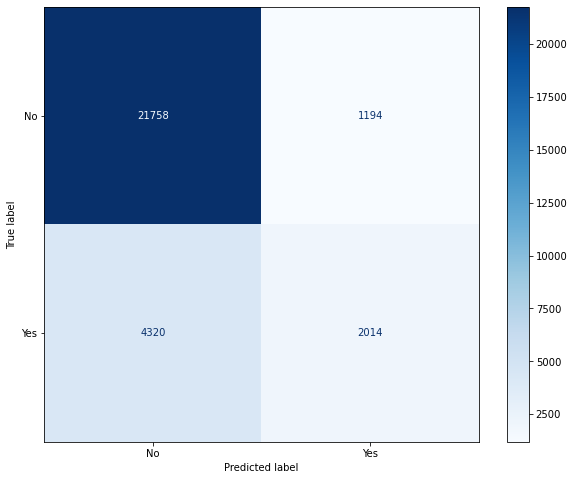

In [85]:
cat_boost_model = validate_ens_model(cat_boost_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [86]:
result_cat_boost_model = get_dataframe_for_submission(cat_boost_model)

In [87]:
# send_submit(result_cat_boost_model, 'CatBoost')

100%|████████████████████████████████████████| 335k/335k [00:03<00:00, 98.5kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

In [101]:
# Soft All Models
soft_voting_all_models = get_voting_classifier([
    ('knn_model', knn_model),
    ('xgb_model', xgb_model),
    ('tree_model', ens_tree_model),
    ('cat_boost_model', cat_boost_model),
    ('random_forest_model', ens_random_forest_model)], 'soft')

In [102]:
print('****************** ENSEMBLE Soft All Models Voting Classifier ******************')
soft_voting_all_models = create_cross_validation_model(soft_voting_all_models, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft All Models Voting Classifier ******************
[12:20:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6903389	total: 28.3ms	remaining: 113ms
1:	learn: 0.6873375	total: 56.7ms	remaining: 85.1ms
2:	learn: 0.6843397	total: 83.5ms	remaining: 55.6ms
3:	learn: 0.6812588	total: 111ms	remaining: 27.8ms
4:	learn: 0.6784722	total: 139ms	remaining: 0us
[12:21:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6902916	total: 32.7ms	remaining: 131ms
1:	learn: 0.6873084	total: 65.8ms	remaining: 98.8ms
2:	learn: 0.6842404	total: 103ms	remaining: 68.8ms
3:	lear

[12:23:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6902852	total: 33.7ms	remaining: 135ms
1:	learn: 0.6872410	total: 69.1ms	remaining: 104ms
2:	learn: 0.6842010	total: 102ms	remaining: 67.8ms
3:	learn: 0.6810886	total: 137ms	remaining: 34.2ms
4:	learn: 0.6780721	total: 169ms	remaining: 0us
Acurácia (Treino): 0.87
Acurácia (Teste): 0.8
              precision    recall  f1-score   support

          NO       0.81      0.98      0.89     22952
         YES       0.68      0.17      0.27      6334

    accuracy                           0.80     29286
   macro avg       0.74      0.57      0.58     29286
weighted avg       0.78      0.80      0.75     29286



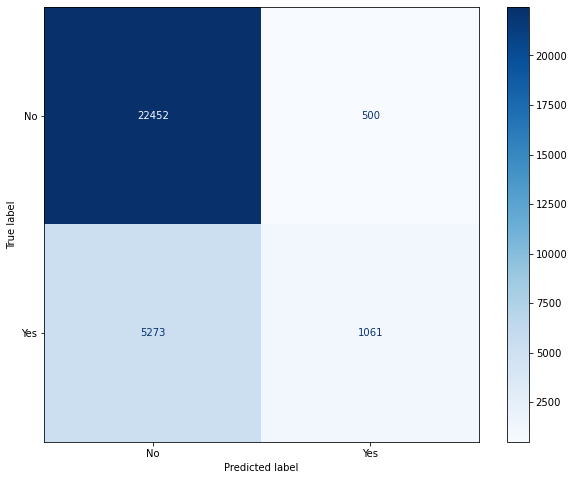

In [103]:
soft_voting_all_models = validate_ens_model(soft_voting_all_models, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [104]:
result_soft_voting_all_models = get_dataframe_for_submission(soft_voting_all_models)

In [105]:
# send_submit(result_soft_voting_all_models, 'Soft All Models')

100%|█████████████████████████████████████████| 336k/336k [00:03<00:00, 109kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final